In [20]:
import scipy.io
import matplotlib.pyplot as plt

data = scipy.io.loadmat('Brain.mat')

data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'T1', 'label'])

# Data Exploration

In [21]:
# Label names
label_names = ['air', 'skin/scalp', 'skull', 'CSF', 'Gray Matter', 'White Matter']

In [22]:
mri_stacked = data['T1']
mri_labels = data['label']

print(mri_stacked.shape)
print(mri_labels.shape)

(362, 434, 10)
(362, 434, 10)


In [23]:
# Max and min label
print(mri_labels[:,:,0].max())
print(mri_labels[:,:,0].min())

5
0


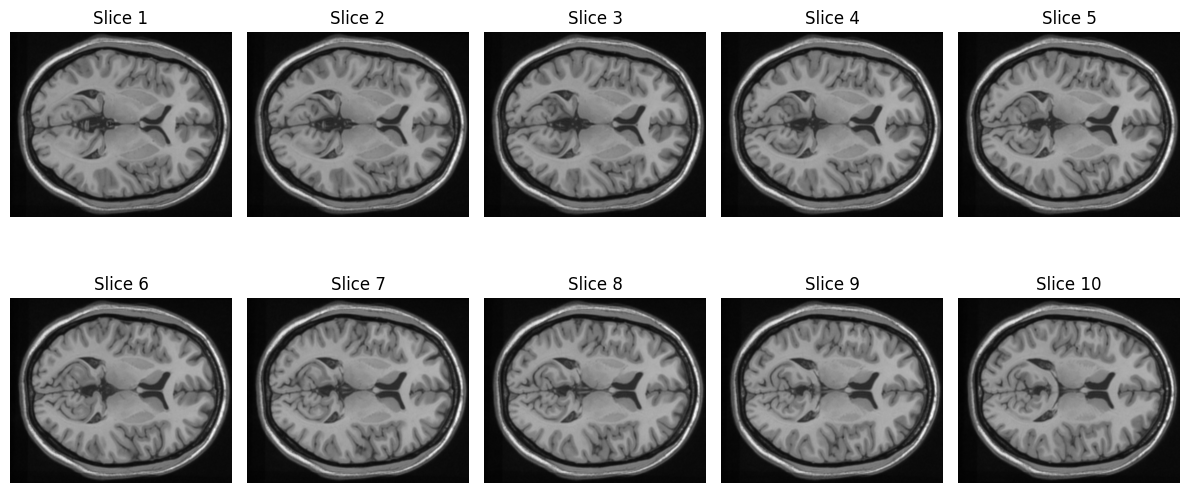

In [24]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(mri_stacked[:, :, i], cmap='gray')
    ax.set_title(f'Slice {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

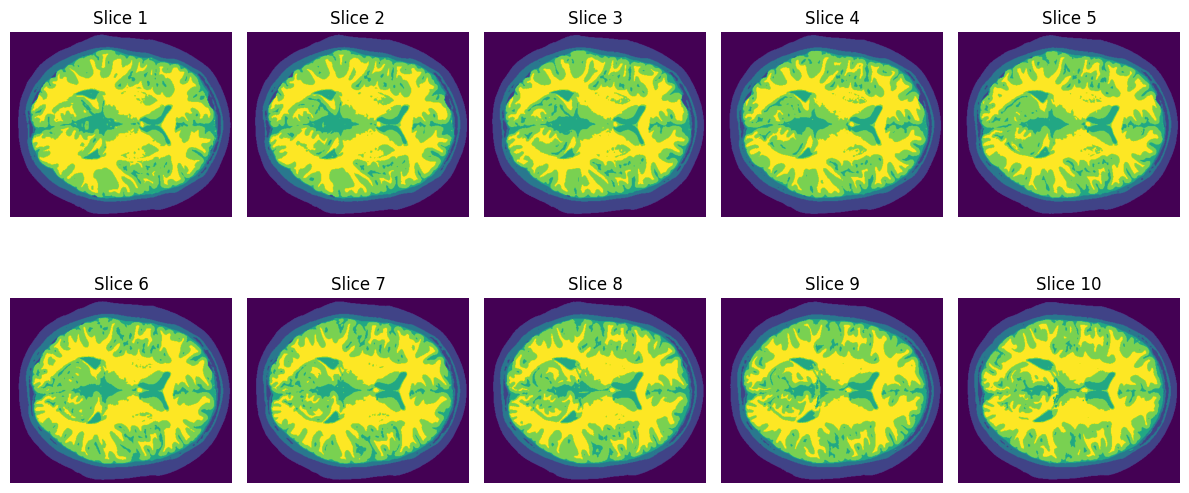

In [25]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(mri_labels[:, :, i])
    ax.set_title(f'Slice {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

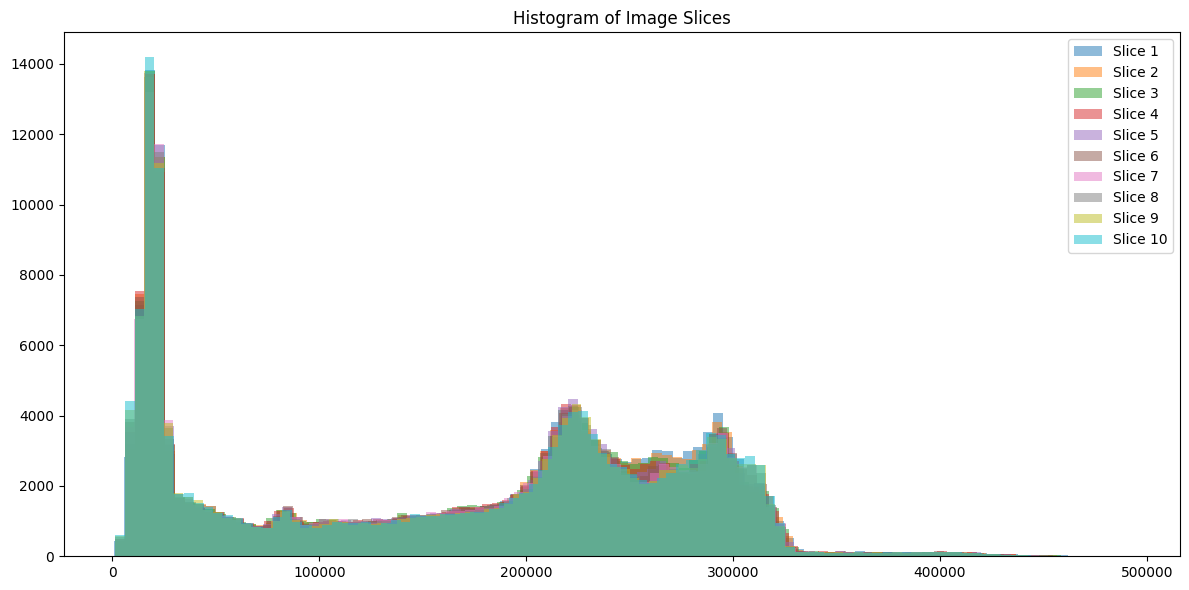

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(mri_stacked.shape[2]):
    hist = plt.hist(mri_stacked[:, :, i].flatten(), bins=100, alpha=0.5, label=f'Slice {i+1}')

ax.set_title('Histogram of Image Slices')
ax.legend()

plt.tight_layout()
plt.show()


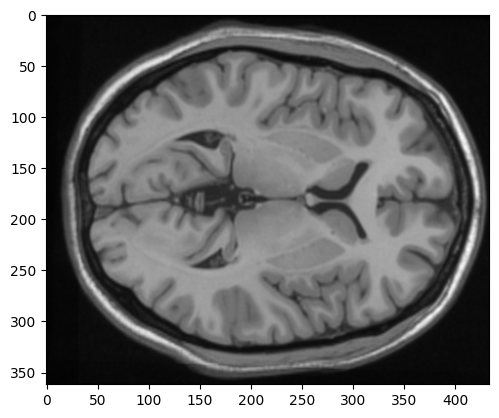

In [27]:
reference_img = mri_stacked[:,:,0]
# Normalize the image
reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

plt.imshow(reference_img, cmap='gray')

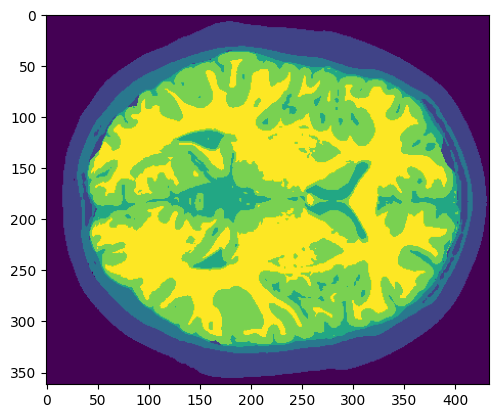

In [28]:
reference_labels = mri_labels[:,:,0]
plt.imshow(reference_labels)

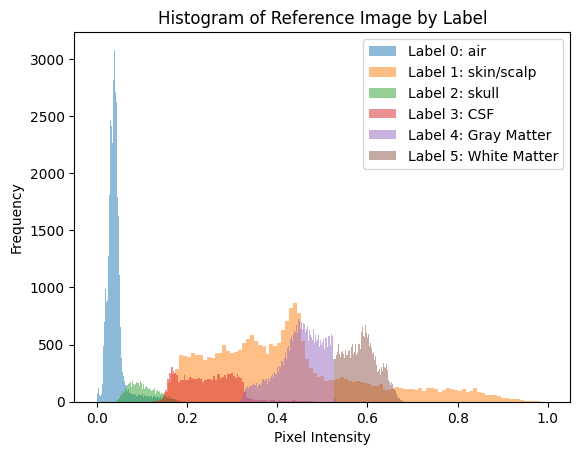

In [29]:
import numpy as np


def plot_frequencies(reference_img, reference_labels, labels2plot = list(range(6))):

    # Initialize an empty list to store the histograms
    histograms = []

    # Iterate over unique labels
    for label in labels2plot:
        # Select the pixels with the current label
        pixels = reference_img[reference_labels == label]
        
        # Plot the histogram of the selected pixels
        hist = plt.hist(pixels.flatten(), bins=100, alpha=0.5, label=f'Label {label}: {label_names[label]}')
        
        # Append the histogram to the list
        histograms.append(hist)

    # Show the legend
    plt.legend()

    # Set the title and labels
    plt.title('Histogram of Reference Image by Label')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

plot_frequencies(reference_img, reference_labels)


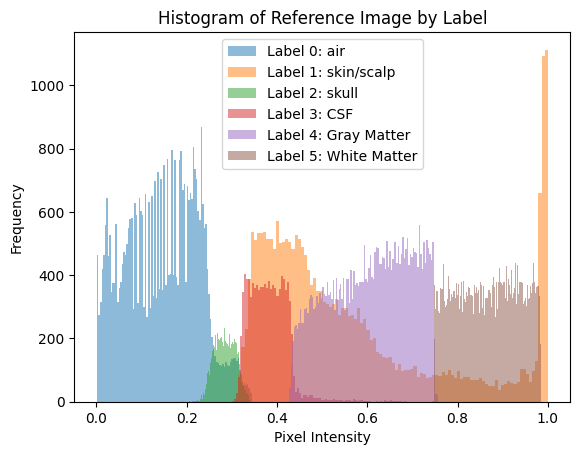

In [30]:
# apply histogram equalization to the reference image
from skimage.exposure import equalize_hist

# Apply histogram equalization
reference_img_eq = equalize_hist(reference_img)

plot_frequencies(reference_img_eq, reference_labels)

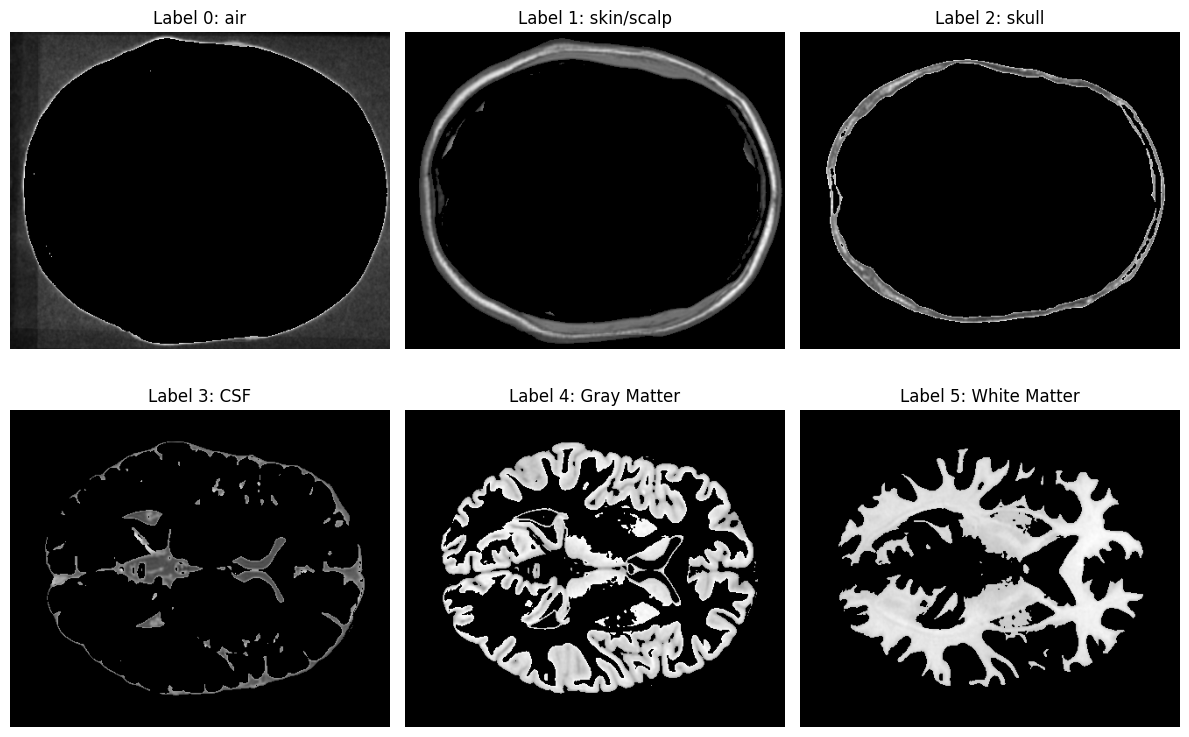

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    mask = reference_img * (reference_labels == i)
    ax.imshow(mask.reshape(reference_img.shape), cmap='gray')
    ax.set_title(f'Label {i}: {label_names[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


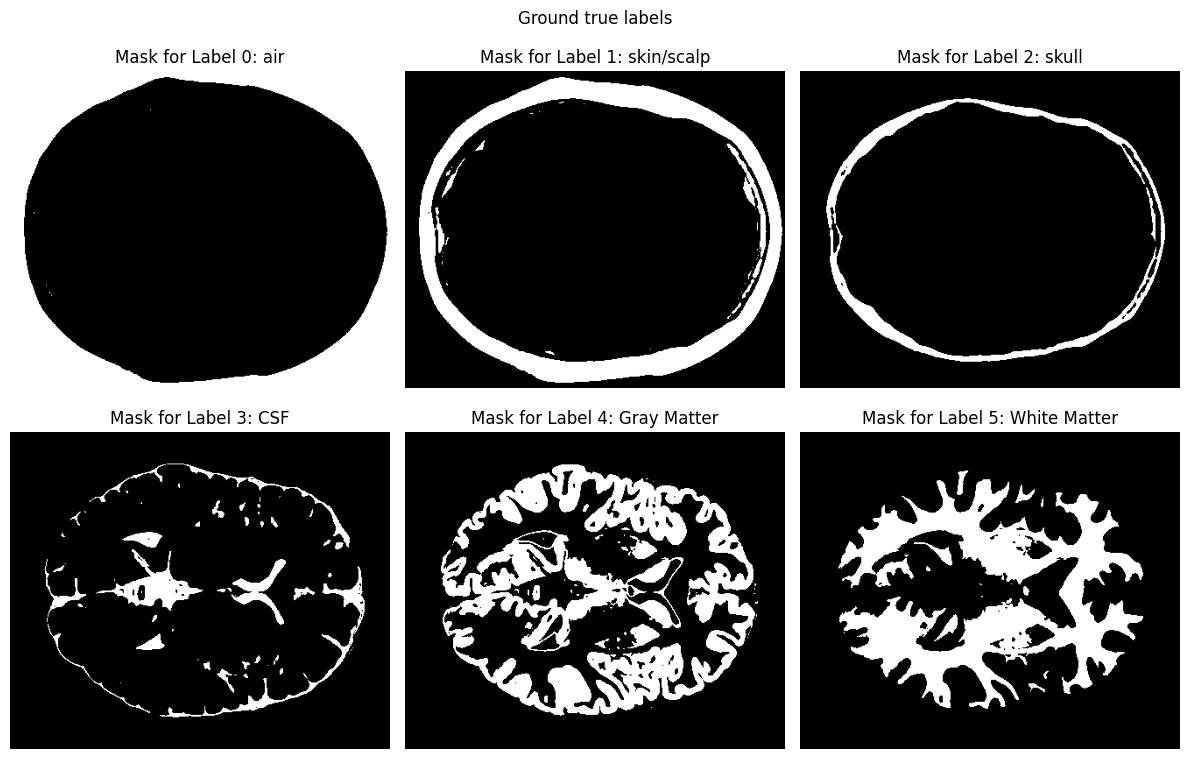

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(reference_labels == i, cmap='gray')
    ax.set_title(f'Mask for Label {i}: {label_names[i]}')
    ax.axis('off')

plt.suptitle("Ground true labels")
plt.tight_layout()
plt.show()


# Segmentation Algorithm

In [33]:
# Relevant Libraries
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes
import scipy.ndimage as ndimage
from skimage.morphology import convex_hull_image
from sklearn.cluster import KMeans

In [34]:
def kmeans_segmentation(image, n_clusters=4):
    # Reshape the image to a 2D array
    X = image.reshape(-1, 1)

    # Fit KMeans to the data
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

    # Predict the labels for the data
    labels = kmeans.predict(X)

    # Reshape the labels to the original image shape
    labels = labels.reshape(image.shape)

    # Get the centroids of the clusters
    centroids = kmeans.cluster_centers_

    # Order the centroids and return the indices
    order = np.argsort(centroids, axis=0)

    return labels, order

In [39]:
# Plot temporal masks
def plot_masks(temporal_masks, rows=1, cols=2, slice_id = 0):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

    flatten_axes = axes.flat
    for ax, (key, mask) in zip(flatten_axes, temporal_masks.items()):
        ax.imshow(mask[:,:,slice_id], cmap='gray')
        ax.set_title(f'Mask: {key}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [72]:
def temporal_masks2final_segmented_mask(temporal_masks, labels = range(6), slice_id = 0):
    segmented_labels = np.zeros_like(temporal_masks["0"][:,:,slice_id])

    # Accumulate all the temporal masks in the segmented_labels
    for label in labels:
        mask = temporal_masks[str(label)][:,:,slice_id]
        segmented_labels[mask == 1] = label

    return segmented_labels

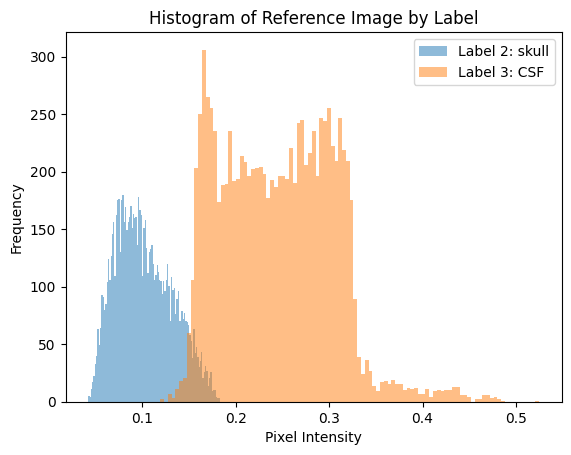

In [37]:
plot_frequencies(reference_img, reference_labels, labels2plot = [2, 3])


In [38]:
# segmented_labels is my prediction and reference_labels is the ground truth
from sklearn.metrics import jaccard_score, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
import numpy as np

# segmented_labels is my prediction and reference_labels is the ground truth
def calculate_metrics(reference_labels, segmented_labels, experiment_name = None):

    if experiment_name:
        print(f"Metrics for {experiment_name}", "\n")

    # Flatten the arrays
    y_true = reference_labels.flatten()
    y_pred = segmented_labels.flatten()

    # Compute the metrics
    accuracy = accuracy_score(y_true, y_pred)
    jaccard_index = jaccard_score(y_true, y_pred, average=None)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)

    # Compute micro metrics
    micro_jaccard = jaccard_score(y_true, y_pred, average='micro')
    micro_precision = precision_score(y_true, y_pred, average='micro')
    micro_recall = recall_score(y_true, y_pred, average='micro')
    micro_f1 = f1_score(y_true, y_pred, average='micro')

    # Compute macro metrics
    macro_jaccard = jaccard_score(y_true, y_pred, average='macro')
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    # Print the rounded metrics
    # print("accuracy:", round(accuracy, 4))
    # print("Jaccard Index:", np.round(jaccard_index, 4))
    # print("Precision:", np.round(precision, 4))
    # print("Recall:", np.round(recall, 4))
    # print("F1 Score:", np.round(f1, 4), "\n")

    # print("Micro Jaccard Index:", round(micro_jaccard, 4))
    # print("Micro Precision:", round(micro_precision, 4))
    # print("Micro Recall:", round(micro_recall, 4))
    # print("Micro F1 Score:", round(micro_f1, 4), "\n")

    # print("Macro Precision:", round(macro_precision, 4))
    # print("Macro Recall:", round(macro_recall, 4))
    # print("Macro F1 Score:", round(macro_f1, 4))
    # print("Macro Jaccard Index:", round(macro_jaccard, 4))

    # Save the average=none metrics in a dictionary by label from 0 to 
    metrics_by_label = {}
    
    for i in range(6):
        metrics_by_label[f"jaccard label {i}"] = np.round(jaccard_index[i], 4)
        # metrics_by_label[f"precision label {i}"] = np.round(precision[i], 4)
        # metrics_by_label[f"recall label {i}"] = np.round(recall[i], 4)
        metrics_by_label[f"f1 label {i}"] = np.round(f1[i], 4)


    # Save the metrics in a dictionary
    metrics = {
        "accuracy": round(accuracy, 4),
        "micro_jaccard": round(micro_jaccard, 4),
        # "micro_precision": round(micro_precision, 4),
        # "micro_recall": round(micro_recall, 4),
        "micro_f1": round(micro_f1, 4),
        "macro_jaccard": round(macro_jaccard, 4),
        # "macro_precision": round(macro_precision, 4),
        # "macro_recall": round(macro_recall, 4),
        "macro_f1": round(macro_f1, 4)
    }

    return metrics,  metrics_by_label


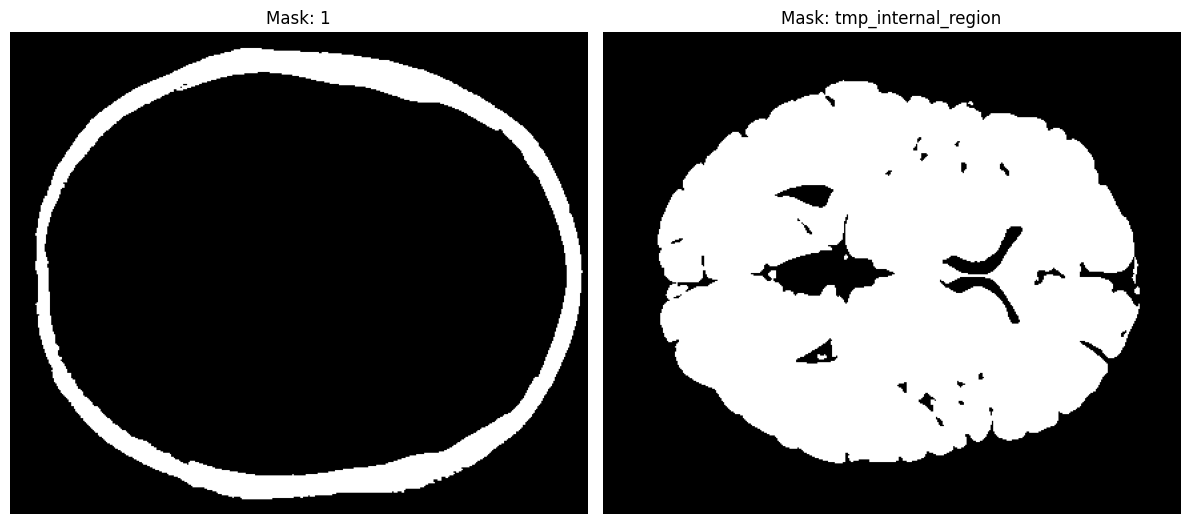

In [57]:
from skimage.feature import canny
from skimage.morphology import binary_opening, binary_closing, disk


# Normalize mri_stacked image
mri_stacked = (mri_stacked - mri_stacked.min()) / (mri_stacked.max() - mri_stacked.min())

temporal_masks = {}

# Equilize reference image
# NOTE: it doesn't work in 3d images
# reference_img_eq = equalize_hist(reference_img)

# Apply an outsu algorithm to the reference image
threshold = threshold_otsu(mri_stacked)
binary = mri_stacked > threshold

# Remove the smaller artificts (holes and objects)
cleaned = remove_small_holes(binary)
cleaned = remove_small_objects(cleaned, min_size=1000)

# Apply two-pass algorithm to the cleaned image to have preliminary labels
labels, num_labels = ndimage.label(cleaned)

# NOTE: I got 3 labels, but I save only the first label
# Save the temporal mask label 1
temporal_masks["1"] = (labels == 1).astype(int)
temporal_masks["tmp_internal_region"] = (labels == 2).astype(int)

plot_masks(temporal_masks, rows=1, cols=2, slice_id = 0)

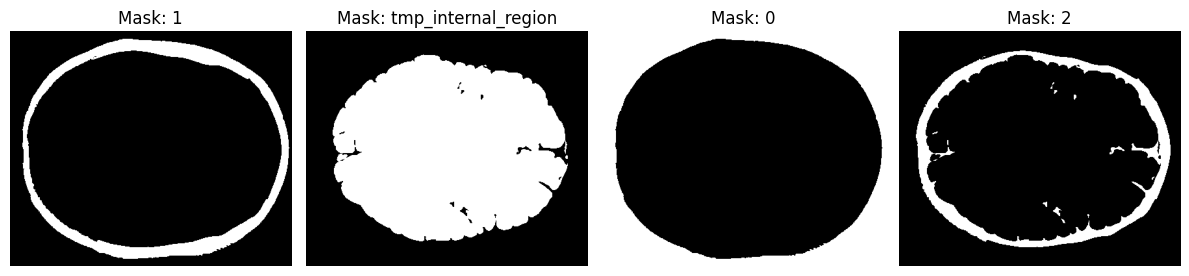

In [60]:
# Invert the cleaned image
inverted = ~cleaned

# Got the others labels from the inverted image
# using the same two-pass algorithm
inverted_labels, num_labels = ndimage.label(inverted)

# Only consider the two first labels and all the other to zero
inverted_labels[inverted_labels > 2] = 0

# Save temporal masks label 0 and 2
temporal_masks["0"] = (inverted_labels == 1).astype(int)
temporal_masks["2"] = (inverted_labels == 2).astype(int)

# Got the tmp internal region by considering all that is
# not part of the mask 0, 1, 2
tmp_mask = temporal_masks["0"] + temporal_masks["1"] + temporal_masks["2"]
temporal_masks["tmp_internal_region"] = (tmp_mask == 0).astype(int)

# Plot the temporal masks
plot_masks(temporal_masks, rows=1, cols=4, slice_id = 0)

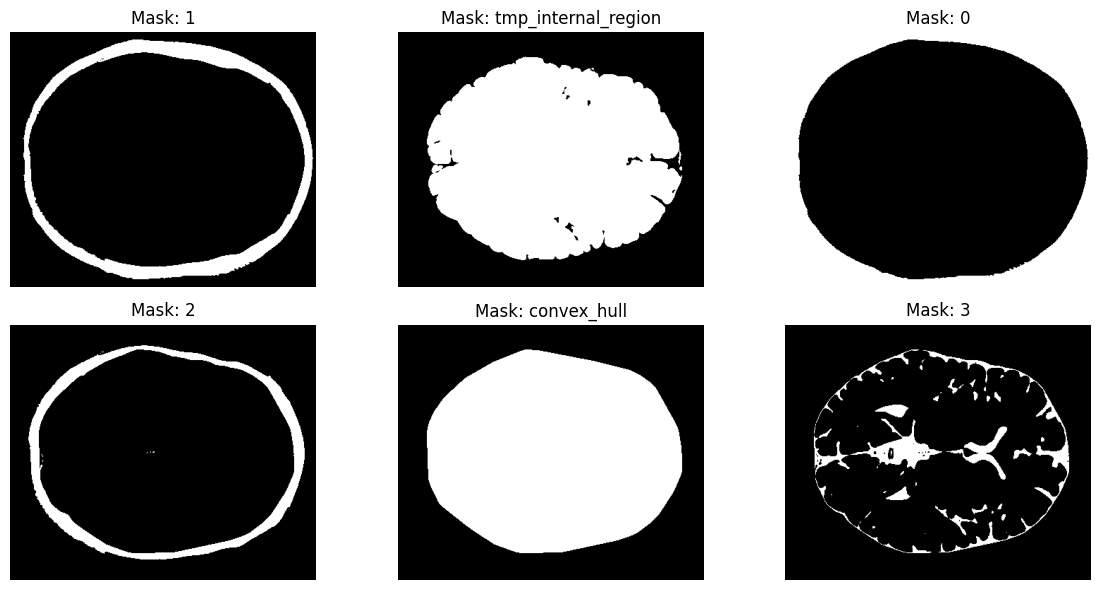

In [63]:
# NOTE: some step here is the one that last more time
# Apply the convex hull to the tmo_internal_region
convex_hull = convex_hull_image(temporal_masks["tmp_internal_region"])

# Save the convex hull mask in the temporal masks
temporal_masks["convex_hull"] = convex_hull.astype(int)

# Apply the convex hull to the mask1
masked_convex_hull = mri_stacked * convex_hull

# Apply k-means clustering to the partial_reference image
# NOTE: one alternative is apply otsu or constant thresholds
internal_labels, order = kmeans_segmentation(masked_convex_hull, n_clusters=4)

# Use the order to fit the mask 3, 4, 5
# NOTE: I don't use order 0 because it corresponds to the external region
temporal_masks["3"] = (internal_labels == order[1]).astype(int)
temporal_masks["4"] = (internal_labels == order[2]).astype(int)
temporal_masks["5"] = (internal_labels == order[3]).astype(int)

# NOTE: There are certain difference between the convex hull 
# and the internal region, which consequently affect the
# k-means clustering, and mask 2. Then, I need to refine
# the mask 2

# Refine the mask 2 by considering all the others masks
tmp_mask = ( temporal_masks["0"] + temporal_masks["1"] +
            temporal_masks["3"] + temporal_masks["4"] +
            temporal_masks["5"] )
temporal_masks["2"] = (tmp_mask == 0).astype(int)

# Plot the temporal masks
plot_masks(temporal_masks, rows=2, cols=3, slice_id = 0)

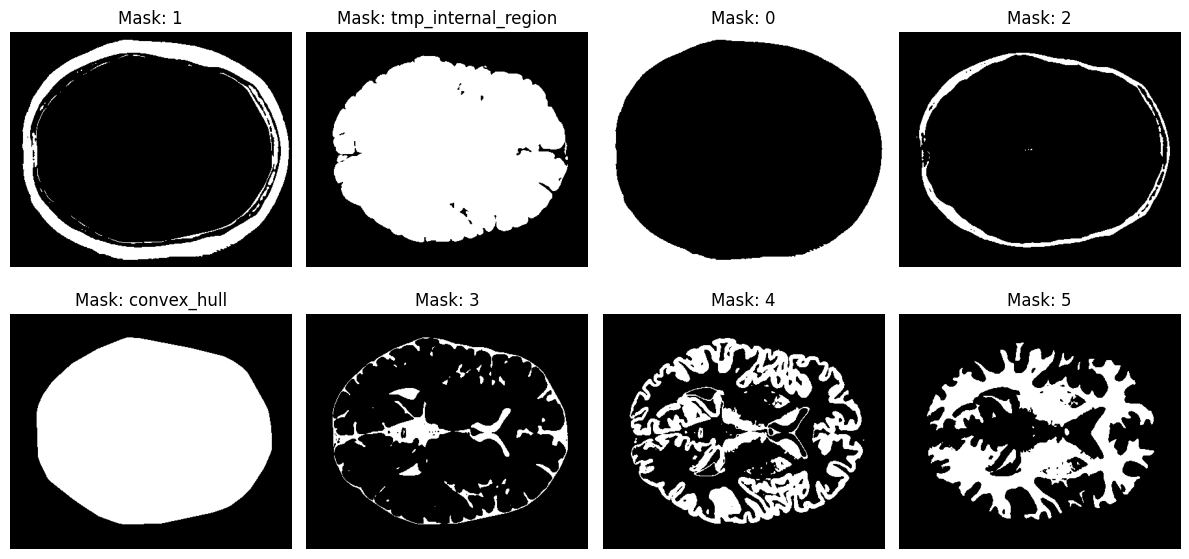

In [68]:
# NOTE: In the ground trues, the mask 1 and 2 have some
# parts in between each other. Then, I need to refine 
# these two masks

# Add the mask 1 and 2 in a tmp_mask
tmp_mask = temporal_masks["1"] + temporal_masks["2"]

# Apply tmp_mask to the reference image
tmp_masked = mri_stacked * tmp_mask

# Add together the mask 1 and 2 in a segmented image
# segmented_img = temporal_masks2final_segmented_mask(temporal_masks, labels = [1, 2, 3])

# # Plot histograms frequencies of the mask 1 and 2
# plot_frequencies(reference_img, segmented_img, labels2plot = [1, 2, 3])

# Apply outsu algorithm to the masked image
# NOTE: I add some constant value to the threshold
# to improve the segmentation
threshold = threshold_otsu(tmp_masked)
binary = tmp_masked > 0.15
# print(threshold)

# plt.imshow(binary, cmap='gray')
# plt.show()

# Add the refined mask 1 and 2 to the temporal masks
temporal_masks["1"] = binary.astype(int)
temporal_masks["2"] = tmp_mask - binary

plot_masks(temporal_masks, 2, 4)

In [77]:
for slice_idx in range(6):
    segmented_labels = temporal_masks2final_segmented_mask(temporal_masks, slice_id = slice_idx)
    reference_labels = mri_labels[:,:,slice_idx]

    metrics,  metrics_by_label = calculate_metrics(reference_labels, segmented_labels, f"Slice {slice_idx}")

    print(metrics)
    print(metrics_by_label)

Metrics for Slice 0 

{'accuracy': 0.9429, 'micro_jaccard': 0.8919, 'micro_f1': 0.9429, 'macro_jaccard': 0.8677, 'macro_f1': 0.9268}
{'jaccard label 0': 0.9378, 'f1 label 0': 0.9679, 'jaccard label 1': 0.8188, 'f1 label 1': 0.9004, 'jaccard label 2': 0.9085, 'f1 label 2': 0.9521, 'jaccard label 3': 0.7018, 'f1 label 3': 0.8248, 'jaccard label 4': 0.8883, 'f1 label 4': 0.9408, 'jaccard label 5': 0.951, 'f1 label 5': 0.9749}
Metrics for Slice 1 

{'accuracy': 0.9442, 'micro_jaccard': 0.8944, 'micro_f1': 0.9442, 'macro_jaccard': 0.8744, 'macro_f1': 0.9311}
{'jaccard label 0': 0.9366, 'f1 label 0': 0.9672, 'jaccard label 1': 0.8207, 'f1 label 1': 0.9015, 'jaccard label 2': 0.9161, 'f1 label 2': 0.9562, 'jaccard label 3': 0.7288, 'f1 label 3': 0.8432, 'jaccard label 4': 0.8924, 'f1 label 4': 0.9432, 'jaccard label 5': 0.9518, 'f1 label 5': 0.9753}
Metrics for Slice 2 

{'accuracy': 0.9427, 'micro_jaccard': 0.8916, 'micro_f1': 0.9427, 'macro_jaccard': 0.8732, 'macro_f1': 0.9304}
{'jaccard la

In [73]:
slice_idx = 0
segmented_labels = temporal_masks2final_segmented_mask(temporal_masks, slice_id = slice_idx)
reference_labels = mri_labels[:,:,slice_idx]

metrics,  metrics_by_label = calculate_metrics(reference_labels, segmented_labels, f"Slice {slice_idx}")

Metrics for Slice 0 



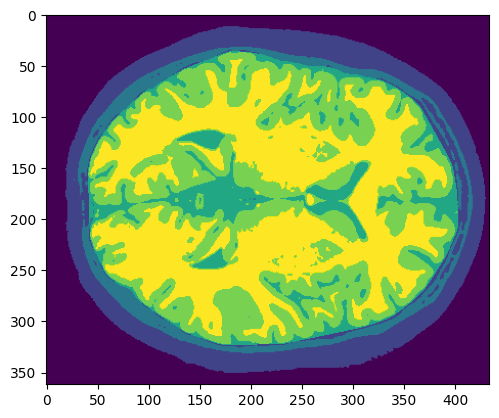

In [74]:
# Plot the segmented image
plt.imshow(segmented_labels)

In [75]:
metrics

{'accuracy': 0.9429,
 'micro_jaccard': 0.8919,
 'micro_f1': 0.9429,
 'macro_jaccard': 0.8677,
 'macro_f1': 0.9268}

In [76]:
metrics_by_label

{'jaccard label 0': 0.9378,
 'f1 label 0': 0.9679,
 'jaccard label 1': 0.8188,
 'f1 label 1': 0.9004,
 'jaccard label 2': 0.9085,
 'f1 label 2': 0.9521,
 'jaccard label 3': 0.7018,
 'f1 label 3': 0.8248,
 'jaccard label 4': 0.8883,
 'f1 label 4': 0.9408,
 'jaccard label 5': 0.951,
 'f1 label 5': 0.9749}

In [178]:
def segmentation_process(reference_img):
    reference_img  = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

    temporal_masks = {}

    # Equilize reference image
    reference_img_eq = equalize_hist(reference_img)

    # Apply an outsu algorithm to the reference image
    threshold = threshold_otsu(reference_img)
    binary = reference_img > threshold

    # Remove the smaller artificts (holes and objects)
    cleaned = remove_small_holes(binary)
    cleaned = remove_small_objects(cleaned, min_size=1000)

    # Apply two-pass algorithm to the cleaned image to have preliminary labels
    labels, num_labels = ndimage.label(cleaned)

    # NOTE: I got 3 labels, but I save only the first label
    # Save the temporal mask label 1
    temporal_masks["1"] = (labels == 1).astype(int)
    temporal_masks["tmp_internal_region"] = (labels == 2).astype(int)

    # Invert the cleaned image
    inverted = ~cleaned

    # Got the others labels from the inverted image
    # using the same two-pass algorithm
    inverted_labels, num_labels = ndimage.label(inverted)

    # Only consider the two first labels and all the other to zero
    inverted_labels[inverted_labels > 2] = 0

    # Save temporal masks label 0 and 2
    temporal_masks["0"] = (inverted_labels == 1).astype(int)
    temporal_masks["2"] = (inverted_labels == 2).astype(int)

    # Got the tmp internal region by considering all that is
    # not part of the mask 0, 1, 2
    tmp_mask = temporal_masks["0"] + temporal_masks["1"] + temporal_masks["2"]
    temporal_masks["tmp_internal_region"] = (tmp_mask == 0).astype(int)

    # Add tmp_internal_region and mask 2
    tmp_mask = temporal_masks["tmp_internal_region"] + temporal_masks["2"]

    # Apply tmp_mask to the reference image
    tmp_masked = reference_img * tmp_mask

    # Apply outsu algorithm to the masked image
    threshold = threshold_otsu(tmp_masked)
    binary = tmp_masked > threshold

    # Plot binary image
    # plt.imshow(binary, cmap='gray')
    # plt.show()

    # Remove small objects from the binary image
    binary = remove_small_objects(binary, min_size=1000)

    # Plot binary image
    # plt.imshow(binary, cmap='gray')
    # plt.show()

    # Apply binary opening to the binary image
    binary = binary_closing(binary, disk(2))

    # Plot binary image
    # plt.imshow(binary, cmap='gray')
    # plt.show()

    # Fill holes in the binary image
    binary = ndimage.binary_fill_holes(binary)

    # Dilate the binary image
    binary = ndimage.binary_dilation(binary)

    # Plot filled image
    # plt.imshow(binary, cmap='gray')
    # plt.show()

    # Save the refined versions
    temporal_masks["tmp_internal_region"] = binary.astype(int)

    # plot the masks
    # plot_masks(temporal_masks, 1, 4)

    # Apply the convex hull to the mask1
    masked_internal_region = reference_img * temporal_masks["tmp_internal_region"]

    # Apply k-means clustering to the partial_reference image
    internal_labels, order = kmeans_segmentation(masked_internal_region, n_clusters=4)

    # Use the order to fit the mask 3, 4, 5
    # NOTE: I don't use order 0 because it corresponds to the external region
    temporal_masks["3"] = (internal_labels == order[1]).astype(int)
    temporal_masks["4"] = (internal_labels == order[2]).astype(int)
    temporal_masks["5"] = (internal_labels == order[3]).astype(int)


    # NOTE: There are certain difference between the convex hull 
    # and the internal region, which consequently affect the
    # k-means clustering, and mask 2. Then, I need to refine
    # the mask 2

    # Refine the mask 2 by considering all the others masks
    tmp_mask = ( temporal_masks["0"] + temporal_masks["1"] +
                temporal_masks["3"] + temporal_masks["4"] +
                temporal_masks["5"] )
    temporal_masks["2"] = (tmp_mask == 0).astype(int)


    # NOTE: In the ground trues, the mask 1 and 2 have some
    # parts in between each other. Then, I need to refine 
    # these two masks

    # Add the mask 1 and 2 in a tmp_mask
    tmp_mask = temporal_masks["1"] + temporal_masks["2"]

    # Apply tmp_mask to the reference image
    tmp_masked = reference_img * tmp_mask

    # Add together the mask 1 and 2 in a segmented image
    # segmented_img = temporal_masks2final_segmented_mask(temporal_masks, labels = [1, 2, 3])

    # # Plot histograms frequencies of the mask 1 and 2
    # plot_frequencies(reference_img, segmented_img, labels2plot = [1, 2, 3])

    # Apply outsu algorithm to the masked image
    # NOTE: I add some constant value to the threshold
    # to improve the segmentation
    threshold = threshold_otsu(tmp_masked)
    binary = tmp_masked > threshold - 0.06
    # print(threshold)

    # # Remove small objects from the binary image
    # binary = remove_small_objects(binary, min_size=5)

    # plt.imshow(binary, cmap='gray')
    # plt.show()

    # Add the refined mask 1 and 2 to the temporal masks
    temporal_masks["1"] = binary.astype(int)
    temporal_masks["2"] = tmp_mask - binary

    return temporal_masks

# Evaluation and Results

In [37]:
# segmented_labels is my prediction and reference_labels is the ground truth
from sklearn.metrics import jaccard_score, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
import numpy as np

# segmented_labels is my prediction and reference_labels is the ground truth
def calculate_metrics(reference_labels, segmented_labels, experiment_name = None):

    if experiment_name:
        print(f"Metrics for {experiment_name}", "\n")

    # Flatten the arrays
    y_true = reference_labels.flatten()
    y_pred = segmented_labels.flatten()

    # Compute the metrics
    accuracy = accuracy_score(y_true, y_pred)
    jaccard_index = jaccard_score(y_true, y_pred, average=None)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)

    # Compute micro metrics
    micro_jaccard = jaccard_score(y_true, y_pred, average='micro')
    micro_precision = precision_score(y_true, y_pred, average='micro')
    micro_recall = recall_score(y_true, y_pred, average='micro')
    micro_f1 = f1_score(y_true, y_pred, average='micro')

    # Compute macro metrics
    macro_jaccard = jaccard_score(y_true, y_pred, average='macro')
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    # Print the rounded metrics
    # print("accuracy:", round(accuracy, 4))
    # print("Jaccard Index:", np.round(jaccard_index, 4))
    # print("Precision:", np.round(precision, 4))
    # print("Recall:", np.round(recall, 4))
    # print("F1 Score:", np.round(f1, 4), "\n")

    # print("Micro Jaccard Index:", round(micro_jaccard, 4))
    # print("Micro Precision:", round(micro_precision, 4))
    # print("Micro Recall:", round(micro_recall, 4))
    # print("Micro F1 Score:", round(micro_f1, 4), "\n")

    # print("Macro Precision:", round(macro_precision, 4))
    # print("Macro Recall:", round(macro_recall, 4))
    # print("Macro F1 Score:", round(macro_f1, 4))
    # print("Macro Jaccard Index:", round(macro_jaccard, 4))

    # Save the average=none metrics in a dictionary by label from 0 to 
    metrics_by_label = {}
    
    for i in range(6):
        metrics_by_label[f"jaccard label {i}"] = np.round(jaccard_index[i], 4)
        # metrics_by_label[f"precision label {i}"] = np.round(precision[i], 4)
        # metrics_by_label[f"recall label {i}"] = np.round(recall[i], 4)
        metrics_by_label[f"f1 label {i}"] = np.round(f1[i], 4)


    # Save the metrics in a dictionary
    metrics = {
        "accuracy": round(accuracy, 4),
        "micro_jaccard": round(micro_jaccard, 4),
        # "micro_precision": round(micro_precision, 4),
        # "micro_recall": round(micro_recall, 4),
        "micro_f1": round(micro_f1, 4),
        "macro_jaccard": round(macro_jaccard, 4),
        # "macro_precision": round(macro_precision, 4),
        # "macro_recall": round(macro_recall, 4),
        "macro_f1": round(macro_f1, 4)
    }

    return metrics,  metrics_by_label


In [202]:
from sklearn.metrics import jaccard_score, accuracy_score
import pandas as pd

# Create an empty dataframe
df_metrics = pd.DataFrame()

df_metrics_by_label = pd.DataFrame()

for i in range(10):
    reference_img = mri_stacked[:,:,i]
    temporal_masks = segmentation_process(reference_img)

    segmented_labels = temporal_masks2final_segmented_mask(temporal_masks)

    metrics,  metrics_by_label = calculate_metrics(mri_labels[:,:,i], segmented_labels, f"Slice {i+1}")

    # metrics is a dictionary. Save as a row in the dataframe
    df_slice = pd.DataFrame(metrics, index=[i])
    df_metrics = df_metrics.append(df_slice)

    # metrics_by_label is a dictionary. Save as a row in the dataframe
    df_slice = pd.DataFrame(metrics_by_label, index=[i])
    df_metrics_by_label = df_metrics_by_label.append(df_slice)


df_metrics.reset_index(drop=True, inplace=True)
df_metrics_by_label.reset_index(drop=True, inplace=True)



Metrics for Slice 1 

Metrics for Slice 2 

Metrics for Slice 3 

Metrics for Slice 4 

Metrics for Slice 5 

Metrics for Slice 6 

Metrics for Slice 7 

Metrics for Slice 8 

Metrics for Slice 9 

Metrics for Slice 10 



In [203]:
df_metrics

,accuracy,micro_jaccard,micro_f1,macro_jaccard,macro_f1
0,0.9416,0.8897,0.9416,0.8643,0.9244
1,0.9383,0.8837,0.9383,0.8561,0.9195
2,0.9355,0.8787,0.9355,0.8555,0.9195
3,0.9344,0.8768,0.9344,0.8504,0.9160
4,0.9353,0.8784,0.9353,0.8527,0.9174
5,0.9384,0.8840,0.9384,0.8575,0.9203
6,0.9387,0.8846,0.9387,0.8574,0.9202
7,0.9422,0.8908,0.9422,0.8600,0.9209
8,0.9425,0.8913,0.9425,0.8587,0.9199
9,0.9438,0.8935,0.9438,0.8596,0.9199


In [204]:
df_metrics_by_label

,jaccard label 0,f1 label 0,jaccard label 1,f1 label 1,jaccard label 2,f1 label 2,jaccard label 3,f1 label 3,jaccard label 4,f1 label 4,jaccard label 5,f1 label 5
0,0.9378,0.9679,0.8191,0.9005,0.9133,0.9547,0.6823,0.8112,0.8823,0.9375,0.9510,0.9749
1,0.9368,0.9673,0.7990,0.8883,0.8908,0.9423,0.6727,0.8043,0.8857,0.9394,0.9518,0.9753
2,0.9367,0.9673,0.8025,0.8904,0.9010,0.9479,0.6839,0.8123,0.8728,0.9321,0.9364,0.9672
3,0.9359,0.9669,0.7944,0.8854,0.8895,0.9415,0.6610,0.7959,0.8774,0.9347,0.9444,0.9714
4,0.9337,0.9657,0.7929,0.8845,0.8949,0.9445,0.6665,0.7999,0.8809,0.9367,0.9476,0.9731
5,0.9370,0.9675,0.8036,0.8911,0.8925,0.9432,0.6728,0.8044,0.8855,0.9393,0.9538,0.9763
6,0.9358,0.9668,0.7958,0.8863,0.8909,0.9423,0.6743,0.8054,0.8890,0.9413,0.9586,0.9789
7,0.9381,0.9680,0.7954,0.8860,0.8897,0.9416,0.6536,0.7905,0.9042,0.9497,0.9791,0.9894
8,0.9392,0.9686,0.8007,0.8893,0.8938,0.9439,0.6423,0.7822,0.9013,0.9481,0.9747,0.9872
9,0.9389,0.9685,0.8005,0.8892,0.9021,0.9486,0.6265,0.7704,0.9055,0.9504,0.9842,0.9920


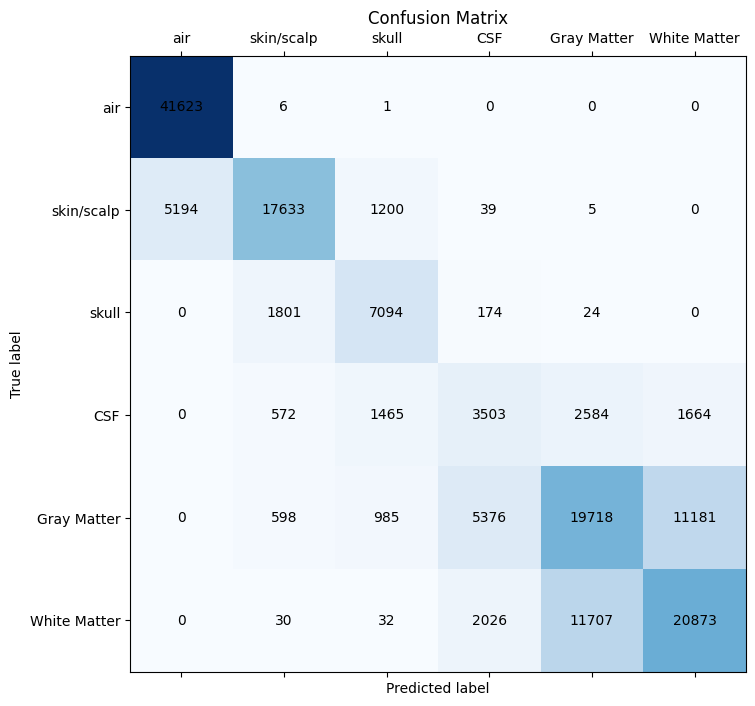

In [207]:
y_true = mri_labels[:,:,0].flatten()
y_pred = segmented_labels.flatten()
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_matrix, cmap='Blues')

# Add the matrix values
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, str(conf_matrix[i, j]), va='center', ha='center')

# Set the title and labels
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Set the ticks
ax.set_xticks(range(6))
ax.set_yticks(range(6))

# Set the labels
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)

# Show the plot
plt.show()
